# Comparaison de variables qualitatives




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

In [3]:
### Instructions pour l'installation dans JupyterLab : 
# https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-in-jupyterlab-3-0
# Utiliser idéalement JupyterLab 3.0

from ipywidgets import (
    interact, IntSlider, Checkbox,
    interactive, SelectMultiple)

In [4]:
### Importer un module de fonctions crée ad hoc
## ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans le même dossier que le présent carnet Jupyter afin que l'importation
#   fonctionne correctement
import sparql_functions as spqf

In [5]:
### Recharger le module après modification des fonctions dans le fichier du module
# désactivé #  
reload(spqf)

<module 'sparql_functions' from '/Volumes/Patientia/python_notebooks/sciences_historiques_numeriques/histoire_numerique/sparql/sparql_functions.py'>

## Base de données

In [4]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [5]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20210529_145120'

In [9]:
##  Noter que la différence de suffixe, en soi totalement arbitraire, 
#  dépend du fait que dans la configuration de .gitignore, .sqlite est exclu du verisonnement GIT
#  contrairement à .db qui est versionné
timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [7]:
### Créer une copie de sauvegarde avec timestamp du fichier (versionnement manuel)
# ATTENTION : la base de données doit exister à l'endroit indiqué !
## Cette requête n'est utile que si des modifications en écriture vont être apportées à la base de données,
# afint de préserver le dernier état avant modification

## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(db, timestamped_db_copy)
copied_db

'data/sparql_queries_20210424_140113.sqlite'

### Appartenance à organisation

In [10]:
query = """
-- institution 
WITH tw0 AS(
SELECT DISTINCT uri_entity,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END organization 
FROM
	property	
WHERE
	property IN ('http://dbpedia.org/ontology/institution')
)
-- Stemming : réduire à la racine du mot, réalisé ici de manière simplifiée en prenant les 5 premiers caractères
SELECT organization, 
CASE 
  WHEN organization LIKE '%univ%' 
          OR organization LIKE '%Sciences_Po%'
          OR organization LIKE '%UCLA%'
          OR organization LIKE '%MIT%'
          OR organization LIKE '%GRIPS%'
          OR organization LIKE '%Massachusetts_i%'
          OR organization LIKE '%colleg%'
          OR organization LIKE '%collèg%'
          OR organization LIKE '%school%'
          OR organization LIKE '%acade%'
          OR organization LIKE '%resear%'
          OR organization LIKE '%polyte%'          
          OR organization LIKE '%étude%'
          OR organization LIKE '%Yale%'
          OR organization LIKE '%Harvard%'
  THEN 'Université'
  WHEN organization LIKE '%fund%' 
          OR organization LIKE '%bureau%'
          OR organization LIKE '%commission%'
          OR organization LIKE '%federal%'                  
          OR organization LIKE '%national%'                  
          OR organization LIKE '%council%'
          OR organization LIKE '%dep%'          
THEN 'Etatique_ou_Paraétatique'
  WHEN organization LIKE '%bank%' 
          OR organization LIKE 'Goldman%'
          OR organization LIKE 'rand%'
          OR organization LIKE '%Tech%'
          OR organization LIKE '%Bell%'
          OR organization LIKE '%bloomb%'
          OR organization LIKE '%citig%'
          OR organization LIKE '%google%'
  THEN 'Banque_Entreprise'
  WHEN organization LIKE '%founda%'
  	  OR organization LIKE '%NBER%'
      OR organization LIKE '%center%' 
      OR organization LIKE '%centre%'
      OR organization LIKE '%instit%'
      OR organization LIKE '%fonda%'
  THEN 'Fondation_Centre'
  ELSE 'Autre'
END AS org_type,  
  count(*) as eff
FROM tw0
group by organization
order by eff desc;"""

In [14]:
### Undirected version of the same graph produced using Pandas
cn = sql.connect(db)
institutions = pd.read_sql_query(query, cn)
cn.close()
institutions.head()

,organization,org_type,eff
0,Harvard_University,Université,63
1,University_of_Chicago,Université,54
2,Stanford_University,Université,48
3,Princeton_University,Université,46
4,Columbia_University,Université,45


In [15]:
instit_classes = institutions.groupby(['org_type']).size()
print(len(instit_classes))
list(instit_classes.sort_values(ascending=False).items())[:100] #[10:20]

5


[('Université', 627),
 ('Autre', 87),
 ('Fondation_Centre', 70),
 ('Etatique_ou_Paraétatique', 35),
 ('Banque_Entreprise', 25)]

## Regroupement des valeurs par 20 ans : générations

In [4]:
### Ouvrir le fichier préparé dans le carnet dbpedia_analyse_nationalites et créer un dataframe

file = 'spreadsheets/continents_annees.csv'
annee_continent = []
with open(file, newline='') as csvfile:
    read = csv.reader(csvfile, delimiter='|', quotechar='"')
    for row in read:
        annee_continent.append(row)

df_annee_continent = pd.DataFrame(annee_continent[1:])
df_annee_continent.columns = annee_continent[0]
df_annee_continent.sort_values('annee').head()

,annee,continent
1140,1773,Europe
1306,1773,Double nat.
1244,1774,Europe
804,1783,Europe
1094,1783,Europe


In [134]:
### Modifier le type de valeur de l'année et le transformer en entier

print(df_annee_continent.dtypes)
data_types_dict = {'annee': int}
df_annee_continent = df_annee_continent.astype(data_types_dict)
print('---')
print(df_annee_continent.dtypes)

annee        object
continent    object
dtype: object
---
annee         int64
continent    object
dtype: object


In [14]:
min(df_annee_continent['annee']), max(df_annee_continent['annee'])

(1773, 1988)

In [140]:
### Créer la liste des périodes de 20 ans, i.e. la liste de la première année de chaque période
d20List = []
period = 20
d_start = 1771
i = 0
d20List.append(d_start)

while i < 11:
    d_start = d_start + period
    d20List.append(d_start)
    i += 1

In [143]:
print(d20List[:2])
min(d20List), max(d20List)

[1771, 1791]


(1771, 1991)

In [168]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
# et coder les années de naissance en relation avec les générations
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

df_annee_continent_generation = df_annee_continent.copy(deep=True)
df_annee_continent_generation['generation'] = pd.cut(df_annee_continent['annee'], d20List, right=False)
# Inspection
df_annee_continent_generation[df_annee_continent_generation['annee']==1891].head()

,annee,continent,generation
77,1891,Europe,"[1891, 1911)"
120,1891,Asie,"[1891, 1911)"
674,1891,Europe,"[1891, 1911)"
934,1891,Am. Nord,"[1891, 1911)"
981,1891,Europe,"[1891, 1911)"


In [169]:
### Transformer le code ajouté pour qu'il soit plus lisible
df_annee_continent_generation['generation'] = df_annee_continent_generation['generation'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))

In [170]:
df_annee_continent_generation.head()

,annee,continent,generation
0,1920,Europe,1911-1931
1,1926,Europe,1911-1931
2,1842,Europe,1831-1851
3,1960,Europe,1951-1971
4,1947,Europe,1931-1951


In [176]:
### Tri à plat: distribution par génération
#  Doc.: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html
pt_generation = pd.pivot_table(df_annee_continent_generation, index=['generation'], values='annee', aggfunc=len,fill_value=0)
print(type(pt_generation))
pt_generation

<class 'pandas.core.frame.DataFrame'>


,annee
generation,
1771-1791,11
1791-1811,4
1811-1831,11
1831-1851,22
1851-1871,45
1871-1891,59
1891-1911,88
1911-1931,207
1931-1951,455


In [157]:
### Alternative : regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
gb_generation = df_annee_continent_generation.groupby('generation').size()
gb_generation

generation
[1771, 1791)     11
[1791, 1811)      4
[1811, 1831)     11
[1831, 1851)     22
[1851, 1871)     45
[1871, 1891)     59
[1891, 1911)     88
[1911, 1931)    207
[1931, 1951)    455
[1951, 1971)    455
[1971, 1991)     69
dtype: int64

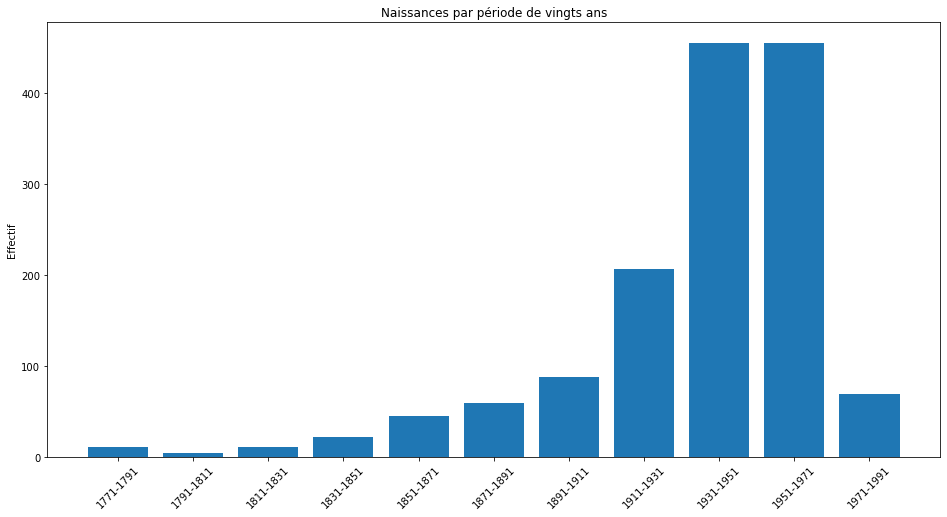

In [177]:
# Distribution par période de 20 ans – cf. dbpedia_analyse_nationalites pour la visualisation interactive des nationalités

objects = [l for l in pt_generation.index]
eff = [l for l in pt_generation['annee']]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de vingts ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


## Restreindre à un siècle et couper par périodes de 10 ans

Chercher à obtenir plus d'homogénéité dans les effectifs : les économistes du 20e siècle (nés dès 1871, actifs dès 1901)

In [159]:
## Les données de départ
df_annee_continent.head()

,annee,continent
0,1920,Europe
1,1926,Europe
2,1842,Europe
3,1960,Europe
4,1947,Europe


In [179]:
### créer un nouveau dataframe et limiter aux valeurs d'année comprises entre 1871 et 1970 (inclus)
df_1871_1970 = df_annee_continent.copy()
df_1871_1970 = df_1871_1970[df_1871_1970.annee.between(left=1871, right=1970)]
print(len(df_1871_1970))
df_1871_1970.sort_values('annee')

1264


,annee,continent
867,1871,Europe
155,1872,Océeanie
366,1872,Am. Nord
657,1872,Europe
348,1873,Am. Nord
...,...,...
671,1970,Europe
483,1970,Am. Nord
412,1970,Am. Nord
28,1970,Europe


In [161]:
y10_list = pd.RangeIndex(start=1871, stop=1970, step=10).to_list()
y10_list

[1871, 1881, 1891, 1901, 1911, 1921, 1931, 1941, 1951, 1961]

In [186]:
### codeer les années les regroupant par décennies : fonction cut

df_1871_1970['decennie'] = pd.cut(df_1871_1970['annee'], y10_list, right=False)
df_1871_1970.head()

,annee,continent,decennie
0,1920,Europe,"[1911, 1921)"
1,1926,Europe,"[1921, 1931)"
3,1960,Europe,"[1951, 1961)"
4,1947,Europe,"[1941, 1951)"
5,1941,Europe,"[1941, 1951)"


In [187]:
### Transformer le code pour qu'il soit plus lisible
df_1871_1970['decennie'] = df_1871_1970['decennie'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
df_1871_1970.head()

,annee,continent,decennie
0,1920,Europe,1911-1921
1,1926,Europe,1921-1931
3,1960,Europe,1951-1961
4,1947,Europe,1941-1951
5,1941,Europe,1941-1951


In [188]:
### Regrouper par continent et compter avec la fonction Pandas 'groupby'
gb_decennie = df_1871_1970.groupby('decennie').size()
gb_decennie

decennie
1871-1881     29
1881-1891     30
1891-1901     37
1901-1911     51
1911-1921     73
1921-1931    134
1931-1941    172
1941-1951    283
1951-1961    271
dtype: int64

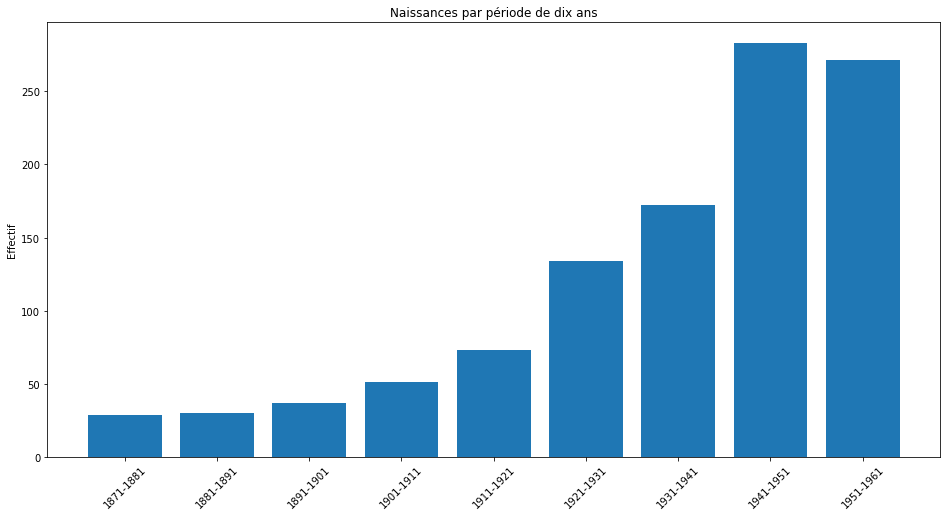

In [180]:
# Distribution par période de 10 ans de la population délimitée

objects = [l for l in gb_decennie.index]
eff = [l for l in gb_decennie]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de dix ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


## Comparer les variables génération courte (10 ans) et nationalité

In [191]:
df_1871_1970.head()

,annee,continent,decennie
0,1920,Europe,1911-1921
1,1926,Europe,1921-1931
3,1960,Europe,1951-1961
4,1947,Europe,1941-1951
5,1941,Europe,1941-1951


In [192]:
### Tableau de contingence décennies-nationalités : effectifs

X = "decennie"  
Y = "continent"

decennie_continent = df_1871_1970[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
decennie_continent

continent,Afrique,Am. Centr.,Am. Nord,Am. Sud,Asie,Double nat.,Europe,Moy. Orient,Océeanie,non_codé
decennie,,,,,,,,,,
1871-1881,0,0,13,0,0,1,13,1,1,0
1881-1891,0,0,16,1,0,3,9,0,1,0
1891-1901,0,0,14,2,2,0,18,0,1,0
1901-1911,0,0,15,1,3,4,27,0,0,1
1911-1921,1,0,33,4,2,6,18,3,6,0
1921-1931,6,0,61,1,9,8,46,1,1,1
1931-1941,10,5,65,6,23,4,51,2,5,1
1941-1951,11,5,96,18,23,14,100,6,6,4
1951-1961,17,6,87,16,27,14,75,11,12,6


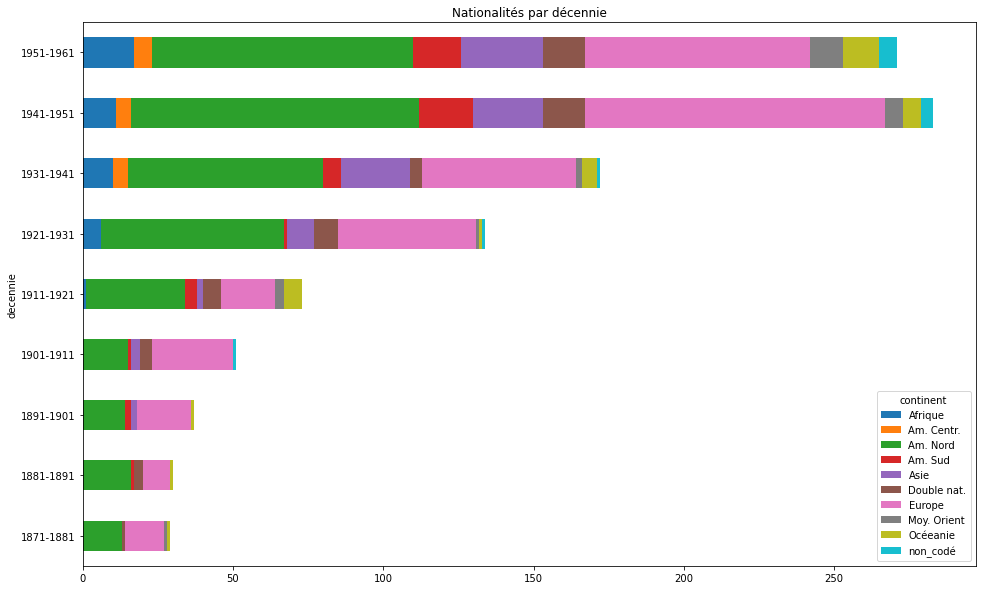

In [194]:
g = decennie_continent.plot( kind='barh', stacked=True,  figsize=(16,10),  title = 'Nationalités par décennie')

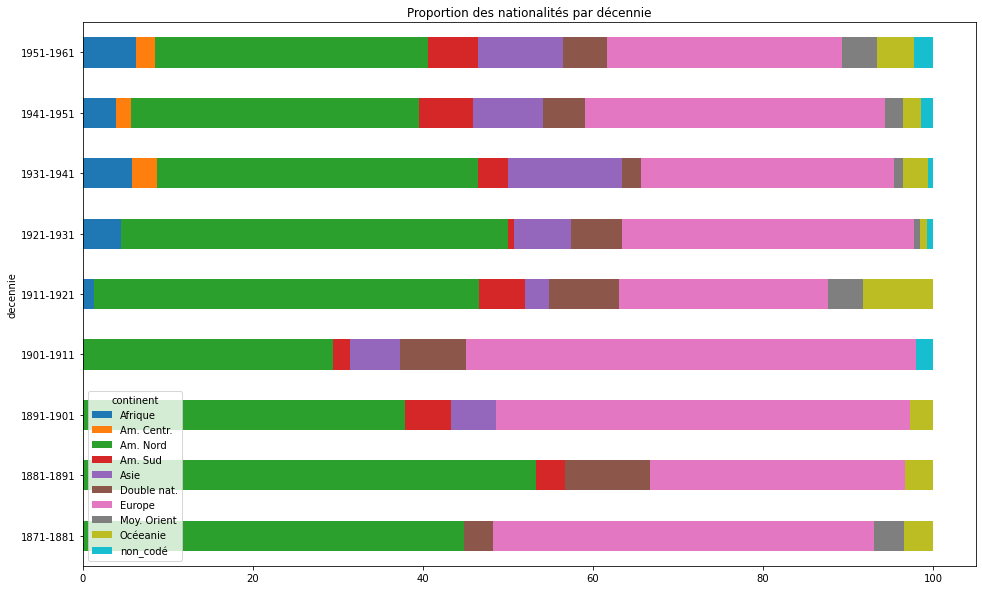

In [39]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/
stacked_data = decennie_continent.apply(lambda x: x*100/sum(x), axis=1)
p = stacked_data.plot(kind="barh", stacked=True, figsize=(16,10), title='Proportion des nationalités par décennie')

## Comparer les quantiles et les nationalités

* Stratégie déconnectée des générations, cherchant à créer des groupes homogènes de population
* L'ensemble de la période est de nouveau prise en compte

In [40]:
df_annee_continent.head()

,annee,continent
0,1920,Europe
1,1926,Europe
2,1842,Europe
3,1960,Europe
4,1947,Europe


In [41]:
df_annee_continent.describe()

,annee
count,1426.000000
mean,1934.510519
std,34.096605
min,1773.000000
25%,1924.000000
50%,1944.000000
75%,1956.000000
max,1988.000000


In [42]:
## Observer les valeurs des quantiles
df_annee_continent['annee'].quantile([0.2,0.4,0.6,0.8])

0.2    1917.0
0.4    1938.0
0.6    1949.0
0.8    1959.0
Name: annee, dtype: float64

In [45]:
## Créer de groupes à effectif homogène, huit groupes (on peut tester avec 10 ou 6, doit être un nombre pair pour les scripts ici)

df_quantiles = df_annee_continent.copy()
df_quantiles['quantile'] = pd.qcut(df_quantiles['annee'], q=8, precision=0) # DOIT ETRE NOMBRE PAIR, precision=0 (default = 3)

In [46]:
###https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Interval.html
a = [print(str(int(l.left))+'-'+str(int(l.right))) for l in df_quantiles['quantile'][:5]]

1899-1924
1924-1936
1772-1899
1956-1964
1944-1950


In [47]:
### Transformer le code pour qu'il soit plus lisible
df_quantiles['quantile'] = df_quantiles['quantile'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
df_quantiles.head()

,annee,continent,quantile
0,1920,Europe,1899-1924
1,1926,Europe,1924-1936
2,1842,Europe,1772-1899
3,1960,Europe,1956-1964
4,1947,Europe,1944-1950


In [48]:
quantiles = df_quantiles['quantile'].drop_duplicates().sort_values()
quantiles.to_list()

['1772-1899',
 '1899-1924',
 '1924-1936',
 '1936-1944',
 '1944-1950',
 '1950-1956',
 '1956-1964',
 '1964-1988']

In [49]:
print(len(df_quantiles))
gb_quantiles=df_quantiles.sort_values('quantile').groupby('quantile').size()

1426


In [50]:
df_gb_quantiles = gb_quantiles.to_frame()
df_gb_quantiles.columns = ['effectif']
n_quantiles = int(len(quantiles.to_list())/2)
print(n_quantiles)
print(sum(df_gb_quantiles['effectif']), sum(df_gb_quantiles['effectif'][:n_quantiles]), sum(df_gb_quantiles['effectif'][n_quantiles:]))
gb_quantiles

4
1426 739 687


quantile
1772-1899    183
1899-1924    180
1924-1936    177
1936-1944    199
1944-1950    163
1950-1956    172
1956-1964    194
1964-1988    158
dtype: int64

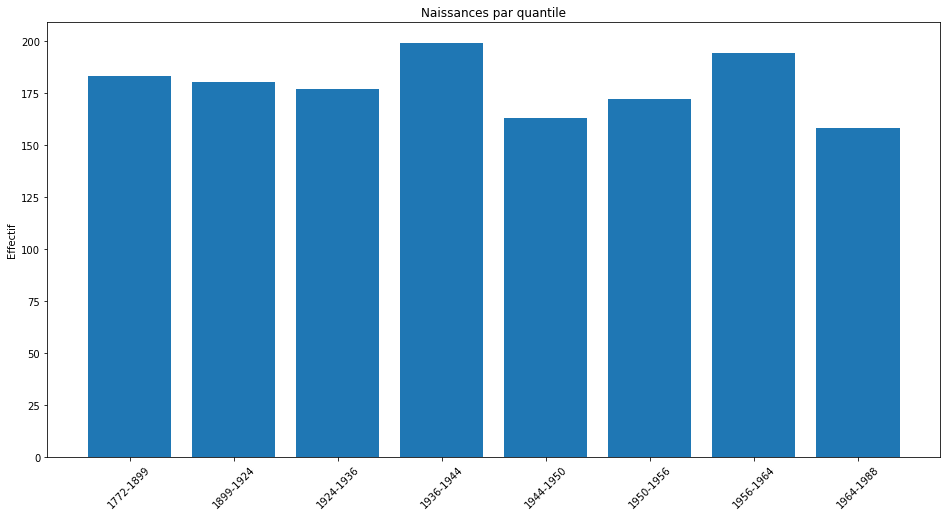

In [52]:
# Distribution par 8 quantiles

objects = [l for l in df_gb_quantiles.index]
eff = [l for l in df_gb_quantiles['effectif']]

p1 = plt.bar(objects, eff)


plt.ylabel('Effectif')
plt.title('Naissances par quantile')
plt.gcf().set_size_inches(16, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


In [53]:
df_quantiles.head()

,annee,continent,quantile
0,1920,Europe,1899-1924
1,1926,Europe,1924-1936
2,1842,Europe,1772-1899
3,1960,Europe,1956-1964
4,1947,Europe,1944-1950


In [77]:
### Tableau de contingence
X = "quantile"  # "0"
Y = "continent"

quantile_continent = df_quantiles[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) #,margins=True,margins_name="Total"
quantile_continent

continent,Afrique,Am. Centr.,Am. Nord,Am. Sud,Asie,Double nat.,Europe,Moy. Orient,Océeanie,non_codé
quantile,,,,,,,,,,
1772-1899,1,0,65,3,3,9,98,1,3,0
1899-1924,1,0,70,7,7,14,69,4,7,1
1924-1936,14,4,72,4,22,7,48,2,3,1
1936-1944,6,2,87,13,15,6,60,4,4,2
1944-1950,7,4,42,8,16,9,68,2,4,3
1950-1956,10,5,58,8,16,12,47,5,7,4
1956-1964,15,3,51,15,20,7,65,6,8,4
1964-1988,15,2,28,11,10,9,74,4,4,1


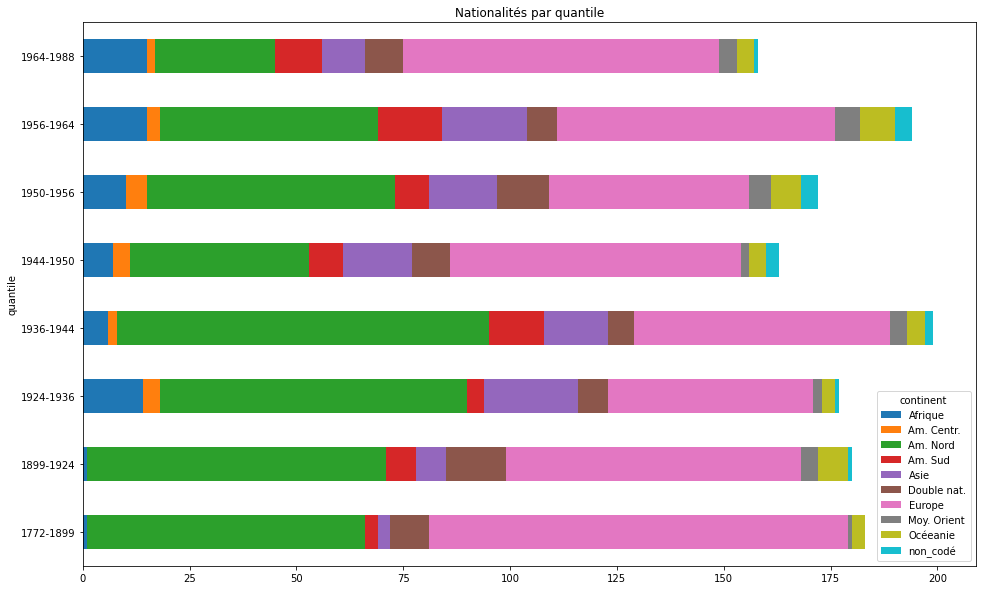

In [56]:
g = quantile_continent.plot( kind='barh', stacked=True,  figsize=(16,10),  title = 'Nationalités par quantile')

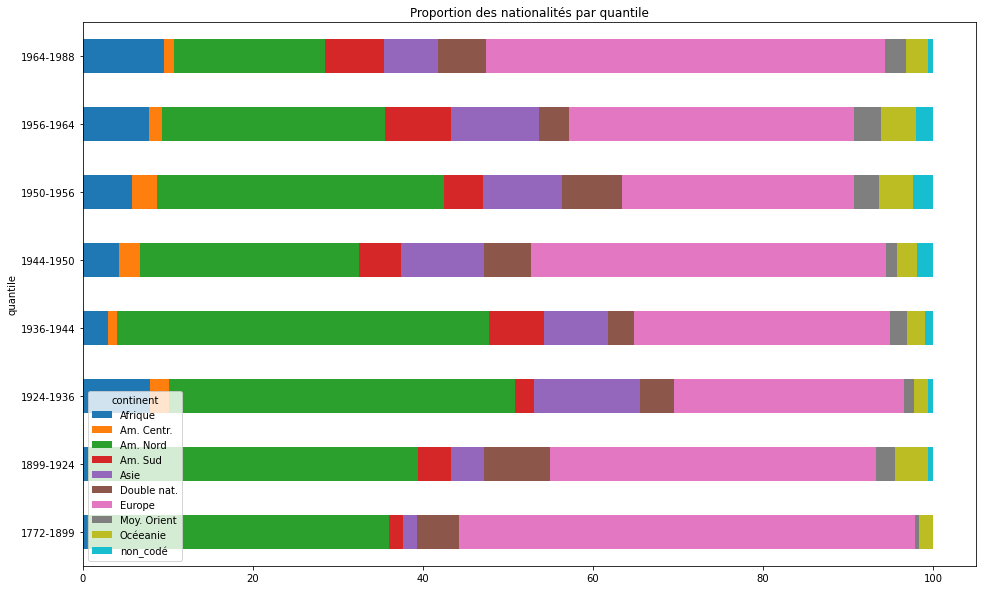

In [75]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

## pourcentages des lignes
stacked_data = quantile_continent.apply(lambda x: x*100/sum(x), axis=1)
plot = stacked_data.plot(kind="barh", stacked=True, figsize=(16,10), title='Proportion des nationalités par quantile')


In [58]:
pd.options.display.float_format = '{0:4.4}'.format
stacked_data

continent,Afrique,Am. Centr.,Am. Nord,Am. Sud,Asie,Double nat.,Europe,Moy. Orient,Océeanie,non_codé
quantile,,,,,,,,,,
1772-1899,0.5464,0.0,35.52,1.639,1.639,4.918,53.55,0.5464,1.639,0.0
1899-1924,0.5556,0.0,38.89,3.889,3.889,7.778,38.33,2.222,3.889,0.5556
1924-1936,7.91,2.26,40.68,2.26,12.43,3.955,27.12,1.13,1.695,0.565
1936-1944,3.015,1.005,43.72,6.533,7.538,3.015,30.15,2.01,2.01,1.005
1944-1950,4.294,2.454,25.77,4.908,9.816,5.521,41.72,1.227,2.454,1.84
1950-1956,5.814,2.907,33.72,4.651,9.302,6.977,27.33,2.907,4.07,2.326
1956-1964,7.732,1.546,26.29,7.732,10.31,3.608,33.51,3.093,4.124,2.062
1964-1988,9.494,1.266,17.72,6.962,6.329,5.696,46.84,2.532,2.532,0.6329


## Tableau de contingence pour les décennies (population restreinte à un siècle)

In [100]:
X = "decennie"  # "0"
Y = "continent"

decennie_continent_marges = df_1871_1970[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int) #
decennie_continent_marges

continent,Afrique,Am. Centr.,Am. Nord,Am. Sud,Asie,Double nat.,Europe,Moy. Orient,Océeanie,non_codé,Total
decennie,,,,,,,,,,,
1871-1881,0,0,13,0,0,1,13,1,1,0,29
1881-1891,0,0,16,1,0,3,9,0,1,0,30
1891-1901,0,0,14,2,2,0,18,0,1,0,37
1901-1911,0,0,15,1,3,4,27,0,0,1,51
1911-1921,1,0,33,4,2,6,18,3,6,0,73
1921-1931,6,0,61,1,9,8,46,1,1,1,134
1931-1941,10,5,65,6,23,4,51,2,5,1,172
1941-1951,11,5,96,18,23,14,100,6,6,4,283
1951-1961,17,6,87,16,27,14,75,11,12,6,271


In [117]:
## Décennie continent pourcentages des lignes
pd.options.display.float_format = '{0:3.4}'.format
decennie_continent_marges.apply(lambda x: x*100/sum(x[-1:]), axis=1)

continent,Afrique,Am. Centr.,Am. Nord,Am. Sud,Asie,Double nat.,Europe,Moy. Orient,Océeanie,non_codé,Total
decennie,,,,,,,,,,,
1871-1881,0.0,0.0,44.83,0.0,0.0,3.448,44.83,3.448,3.448,0.0,100.0
1881-1891,0.0,0.0,53.33,3.333,0.0,10.0,30.0,0.0,3.333,0.0,100.0
1891-1901,0.0,0.0,37.84,5.405,5.405,0.0,48.65,0.0,2.703,0.0,100.0
1901-1911,0.0,0.0,29.41,1.961,5.882,7.843,52.94,0.0,0.0,1.961,100.0
1911-1921,1.37,0.0,45.21,5.479,2.74,8.219,24.66,4.11,8.219,0.0,100.0
1921-1931,4.478,0.0,45.52,0.7463,6.716,5.97,34.33,0.7463,0.7463,0.7463,100.0
1931-1941,5.814,2.907,37.79,3.488,13.37,2.326,29.65,1.163,2.907,0.5814,100.0
1941-1951,3.887,1.767,33.92,6.36,8.127,4.947,35.34,2.12,2.12,1.413,100.0
1951-1961,6.273,2.214,32.1,5.904,9.963,5.166,27.68,4.059,4.428,2.214,100.0


### Tableau cas d'indépendance

Produit des marges divisé par le total et arrondi

In [88]:
### Total général, dernière cellule de la dernière ligne
decennie_continent_marges.iat[-1,-1]

1080

In [98]:
tx = decennie_continent_marges.loc[:,["Total"]]
ty = decennie_continent_marges.loc[["Total"],:]
n = decennie_continent_marges.iat[-1,-1] 

### Compute the matrix multiplication between the columns.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dot.html
indep = tx.dot(ty) / n
#pd.options.display.float_format = '{0:3.5}'.format

# Arrondi
print(indep.astype(int))


continent  Afrique  Am. Centr.  Am. Nord  Am. Sud  Asie  Double nat.  Europe  \
decennie                                                                       
1871-1881        1           0        10        1     2            1       9   
1881-1891        1           0        11        1     2            1       9   
1891-1901        1           0        13        1     3            1      12   
1901-1911        2           0        18        2     4            2      16   
1911-1921        3           1        27        3     6            3      24   
1921-1931        5           1        49        6    11            6      44   
1931-1941        7           2        63        7    14            8      56   
1941-1951       11           4       104       12    23           14      93   
1951-1961       11           4       100       12    22           13      89   
Total           45          16       400       49    89           54     357   

continent  Moy. Orient  Océeanie  non_c

In [107]:
### Différence en effectifs entre le théorique et l'observé
### Doc. :
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (decennie_continent_marges-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.astype(int))


continent  Afrique  Am. Centr.  Am. Nord  Am. Sud  Asie  Double nat.  Europe  \
decennie                                                                       
1871-1881       -1           0         2       -1    -2            0       3   
1881-1891       -1           0         4        0    -2            1       0   
1891-1901       -1           0         0        0    -1           -1       5   
1901-1911       -2           0        -3       -1    -1            1      10   
1911-1921       -2          -1         5        0    -4            2      -6   
1921-1931        0          -1        11       -5    -2            1       1   
1931-1941        2           2         1       -1     8           -4      -5   
1941-1951        0           0        -8        5     0            0       6   
1951-1961        5           1       -13        3     4            0     -14   
Total            0           0         0        0     0            0       0   

continent  Moy. Orient  Océeanie  non_c

In [113]:
### Ecarts positifs et pondérés par les effectifs
### Doc. :
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts_ponderes = (decennie_continent_marges-indep)**2/indep
ecarts_ponderes

continent,Afrique,Am. Centr.,Am. Nord,Am. Sud,Asie,Double nat.,Europe,Moy. Orient,Océeanie,non_codé,Total
decennie,,,,,,,,,,,
1871-1881,1.2083,0.42963,0.47522,1.3157,2.3898,0.13966,1.2158,0.19617,0.014638,0.34907,0.0
1881-1891,1.25,0.44444,2.1511,0.095805,2.4722,1.5,0.084734,0.66667,0.0075758,0.36111,0.0
1891-1901,1.5417,0.54815,0.0064064,0.061495,0.36095,1.85,2.7216,0.82222,0.015076,0.44537,0.0
1901-1911,2.125,0.75556,0.80065,0.74606,0.34422,0.82451,6.101,1.1333,1.5583,0.24285,0.0
1911-1921,1.3704,1.0815,1.3151,0.1429,2.6807,1.513,1.5575,1.1702,6.37,0.8787,0.0
1921-1931,0.031095,1.9852,2.605,4.2441,0.37783,0.25224,0.065672,1.3136,2.3387,0.23294,0.0
1931-1941,1.1202,2.3592,0.026378,0.4169,5.4957,2.4605,0.60306,0.86873,0.012427,0.55338,0.0
1941-1951,0.053151,0.15549,0.74132,2.0738,0.0044265,0.0015901,0.44511,0.013271,0.81041,0.10341,0.0
1951-1961,2.8858,0.9816,1.7811,1.1162,0.97555,0.014945,2.3732,4.1145,1.6707,2.2981,0.0


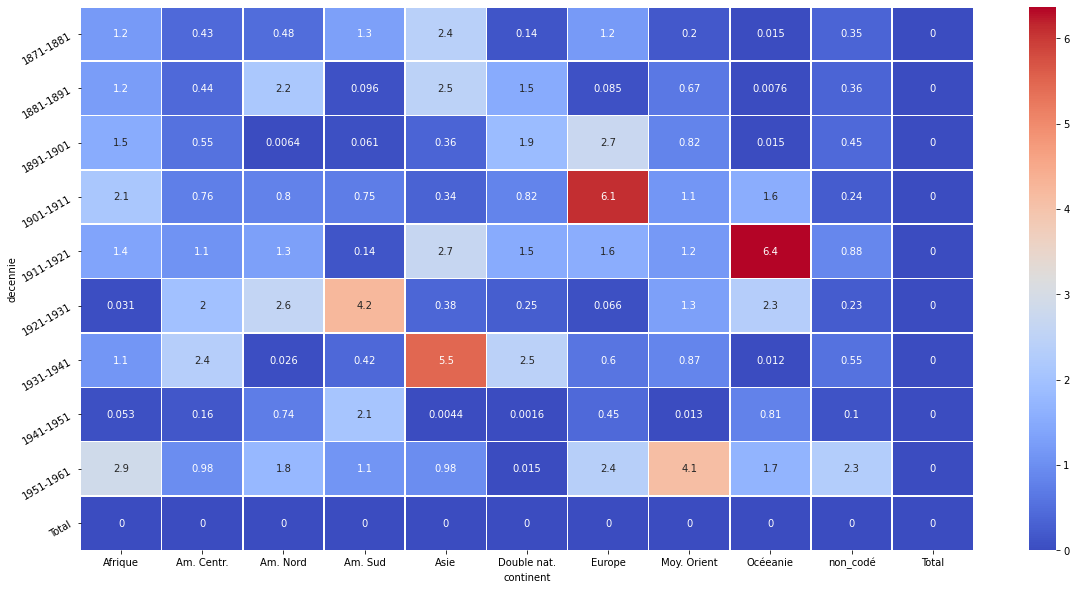

In [115]:
xi_n = measure.sum().sum()
table = measure/xi_n
fig, ax = plt.subplots(figsize=(20,10))         
# Sample figsize in inches
g = sns.heatmap(ecarts_ponderes, annot=ecarts_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = ecarts_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

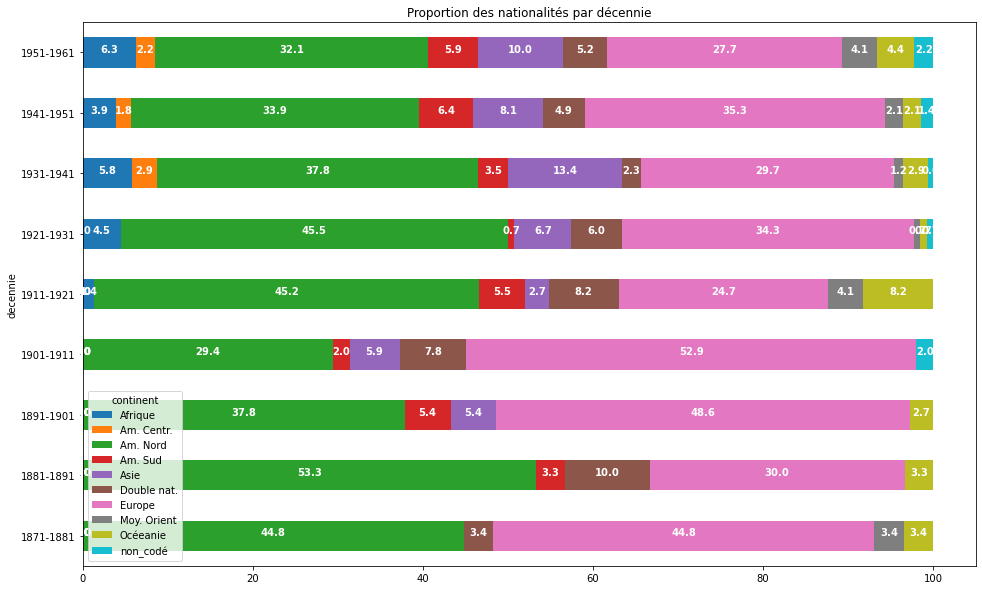

In [288]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/
stacked_data = decennie_continent.apply(lambda x: x*100/sum(x), axis=1)
z = stacked_data.plot(kind="barh", stacked=True, figsize=(16,10), title='Proportion des nationalités par décennie')

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
#b = [(p.get_bbox().bounds, p.get_bbox().xmin,p.get_bbox().ymin, p.get_bbox().ymax, p.get_width(), p.get_y(), p.get_height()) for p in z.patches][59]
#print(b)
for p in z.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    z.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')